In [1]:
# this ensures that the notebook is always reloaded in the same state
from example_utils import *

# remove all previous experiments
!rm -rf my_experiment 
!rm -rf my-talkative-experiments
!rm -rf linear_regression

# Digital Experiments

## The Basics

At its most basic, a digital experiment is a peice of code that takes some inputs and produces some results.

To keep track of these inputs and results automatically, `digital_experiments` provides the `@experiment` decorator:

In [2]:
from digital_experiments import experiment

@experiment
def my_experiment(a, b, power=2):
    return (a - b) ** power + a

Running an experiment and recording the output is as simple as calling the function:

In [3]:
my_experiment(1, 2)

2

We can see that digital_experiments logs that an experiment has occurred, together with the arguments used to run it (including defaults from the function that we didn't pass!)

By default, a folder to hold all of these experiments is created with the name of the function (in this case `my_experiment`). 

Each call of the function corresponds to a single experiment. These are named with the timestep at which they were started (so that they appear in chronological order within file systems) together with a human readable identifier, and appear as sub-folders:

In [4]:
tree("my_experiment")

├── .backend
├── 221117-152825-4181-rosy-baby
│   ├── config.json
│   ├── metadata.json
│   └── results.json
└── code.py


Under-the-hood, `digital_experiments` has saved everything we want to know about this experiment!

We can inspect experiment files directly from the file system:

In [5]:
!cat my_experiment/*/config.json

{
    "a": 1,
    "b": 2,
    "power": 2
}

... and also access them from within python:

In [6]:
from digital_experiments import all_experiments
all_experiments(my_experiment)

,id,config.a,config.b,config.power,results
0,221117-152825-4181-rosy-baby,1,2,2,2


In [7]:
from digital_experiments import convert_to_experiments

df = all_experiments(my_experiment, metadata=True)
convert_to_experiments(df)

[Experiment(id='221117-152825-4181-rosy-baby', config={'a': 1, 'b': 2, 'power': 2}, results=2, metadata={'timing': {'start': 1668698905.418559, 'end': 1668698905.418566}})]

## Advanced Usage

### Logging and Verbosity

The experiment decorator can take several keyword arguments:
- `save_to` specifies the folder to save all experiments to (defaults to the name of the function)
- `capture_logs` - if this is set to True, anything printed from within the experiment is saved to `log`
- `verbose` - controls whether `digital_experiments` prints additional information about each experiment

In [8]:
@experiment(save_to="my-talkative-experiments", verbose=True, capture_logs=True)
def talkative_experiment(a, b, power=2):
    print("Hello!")
    return (a - b) ** power + a

talkative_experiment(1, 2)

Starting new experiment - 221117-152825-9507-ajar-rush
Arguments: {
    "a": 1,
    "b": 2,
    "power": 2
}
Hello!
Finished experiment - 221117-152825-9507-ajar-rush



2

In [9]:
!cat my-talkative-experiments/*/log

Starting new experiment - 221117-152825-9507-ajar-rush
Arguments: {
    "a": 1,
    "b": 2,
    "power": 2
}
Hello!
Finished experiment - 221117-152825-9507-ajar-rush



### Multiple Results and Artefacts

It is often the case that we have more than a single result.
`digital_experiments` can handle these intelligently when they are returned as an (optionally nested) dict.

Artefacts can be automatically be saved in the correct folder using the `current_directory` function:

In [10]:
import pickle
import numpy as np
from sklearn.linear_model import Ridge
from digital_experiments import current_directory

np.random.seed(6)

X = np.random.rand(100, 3) * 20
y = X[:,0] * 2 + X[:,1] * 4 + 2 + np.random.randn(100) * 5


@experiment(verbose=False)
def linear_regression(alpha, fit_intercept=True):
    model = Ridge(alpha, fit_intercept=fit_intercept)
    train, test = slice(0, 10), slice(90, 100)

    model.fit(X[train], y[train])
    yhat = model.predict(X)
    errors = yhat - y

    with open(current_directory() / "model.pkl", "wb") as f:
        pickle.dump(model, f)

    return {
        "mae": {
            name: np.abs(errors[split]).mean()
            for name, split in zip(["train", "test"], [train, test])
        },
    }


linear_regression(alpha=0)

{'mae': {'train': 0.9737829415128569, 'test': 5.615792030139374}}

In [11]:
for alpha in range(1, 10):
    linear_regression(alpha * 5)

Nested results are flattened using ".":

In [12]:
df = all_experiments("linear_regression")
df

,id,config.alpha,config.fit_intercept,results.mae.train,results.mae.test
1,221117-152826-8168-back-gene,0,True,0.973783,5.615792
0,221117-152826-8525-limp-cold,5,True,1.078108,5.240720
4,221117-152826-8562-fake-fuel,10,True,1.304290,4.899661
9,221117-152826-8574-lame-game,15,True,1.575662,4.716825
6,221117-152826-8580-lazy-food,20,True,1.912852,4.628257
3,221117-152826-8587-sore-page,25,True,2.267020,4.550531
7,221117-152826-8594-limp-tour,30,True,2.600822,4.517051
2,221117-152826-8600-tart-kind,35,True,2.916348,4.663442
5,221117-152826-8606-zany-knee,40,True,3.215390,4.804743
8,221117-152826-8612-pink-pass,45,True,3.499491,4.941329


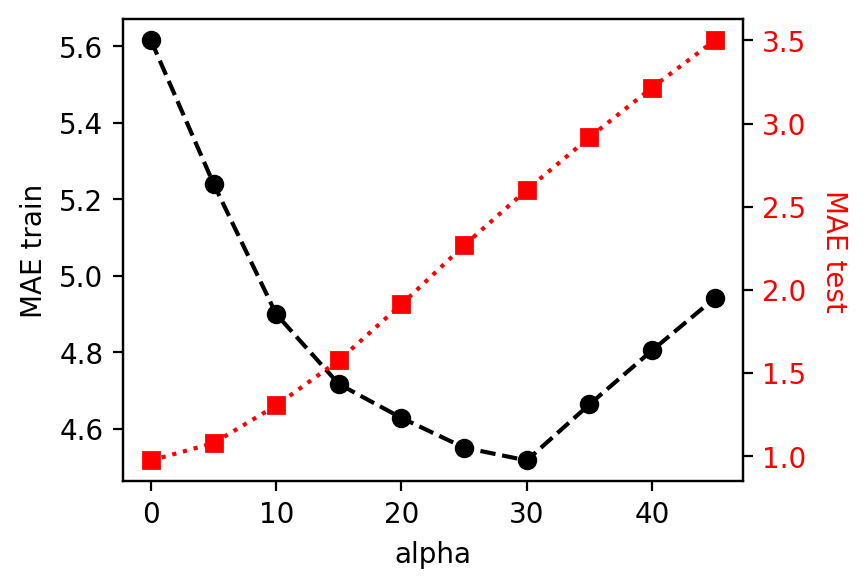

In [13]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(4, 3))
plt.plot(df['config.alpha'], df['results.mae.test'], "--ko")
plt.ylabel("MAE train")
plt.xlabel("alpha");

plt.twinx().plot(df['config.alpha'], df['results.mae.train'], ":rs")
plt.ylabel("MAE test", color="r", rotation=270, labelpad=15);
plt.yticks(color="r");

Artefacts saved during an experiment can be accessed using `.artefacts`: a mapping of filename to actual path.

In [14]:
from digital_experiments import get_artefacts
get_artefacts("linear_regression", df.id[0])

{'model.pkl': PosixPath('linear_regression/221117-152826-8525-limp-cold/model.pkl')}

### Template Matching

When accessing experiments, we can filter them based on their config and results:

In [15]:
from digital_experiments import experiments_matching

# exact matches
experiments_matching("linear_regression", config=dict(alpha=0))

,id,config.alpha,config.fit_intercept,results.mae.train,results.mae.test
1,221117-152826-8168-back-gene,0,True,0.973783,5.615792


In [16]:
# function matches
experiments_matching("linear_regression", config=dict(alpha=lambda x: x < 20))

,id,config.alpha,config.fit_intercept,results.mae.train,results.mae.test
1,221117-152826-8168-back-gene,0,True,0.973783,5.615792
0,221117-152826-8525-limp-cold,5,True,1.078108,5.240720
4,221117-152826-8562-fake-fuel,10,True,1.304290,4.899661
9,221117-152826-8574-lame-game,15,True,1.575662,4.716825


In [17]:
# nested filtering:

template = {"results": {"mae": {"test": lambda x: x < 4.7}}}
experiments_matching("linear_regression", template)

,id,config.alpha,config.fit_intercept,results.mae.train,results.mae.test
6,221117-152826-8580-lazy-food,20,True,1.912852,4.628257
3,221117-152826-8587-sore-page,25,True,2.267020,4.550531
7,221117-152826-8594-limp-tour,30,True,2.600822,4.517051
2,221117-152826-8600-tart-kind,35,True,2.916348,4.663442


## Versions

`digital_experiments` also keeps track of the versions of the code used to run an experiment.
If the code of the experiment changes, a new version is created in the file system (i.e. old experiments are not overwritten). Reverting the code back to an older version will continue writing to the correct folder.

In [18]:
@experiment
def my_experiment(a, b=2):
    return a + b

my_experiment(1)

3

In [19]:
tree("my_experiment")

├── v-1
│   ├── .backend
│   ├── 221117-152825-4181-rosy-baby
│   │   ├── config.json
│   │   ├── metadata.json
│   │   └── results.json
│   └── code.py
└── v-2
    ├── .backend
    ├── 221117-152827-8942-calm-cold
    │   ├── config.json
    │   ├── metadata.json
    │   └── results.json
    └── code.py


In [20]:
!cat my_experiment/*/code.py

@experiment
def my_experiment(a, b, power=2):
    return (a - b) ** power + a
@experiment
def my_experiment(a, b=2):
    return a + b


## Backends

`digital_experiments` can be used with any backend that implements the `Backend` interface.
`json` and `csv` backends are provided out of the box:

In [21]:
@experiment(backend="csv")
def my_experiment(a, b=2):
    return a + b

my_experiment(1)

3

In [22]:
tree("my_experiment")

├── v-1
│   ├── .backend
│   ├── 221117-152825-4181-rosy-baby
│   │   ├── config.json
│   │   ├── metadata.json
│   │   └── results.json
│   └── code.py
├── v-2
│   ├── .backend
│   ├── 221117-152827-8942-calm-cold
│   │   ├── config.json
│   │   ├── metadata.json
│   │   └── results.json
│   └── code.py
└── v-3
    ├── .backend
    ├── code.py
    └── results.csv


In [23]:
!cat my_experiment/v-3/results.csv

id,config.a,config.b,results.results,metadata.timing.start,metadata.timing.end
221117-152828-3699-spry-army,1,2,3,1668698908.371031,1668698908.371034
